### 초기 경로 설정 (클래스 이용을 위함)

In [1]:
%cd /project/segmentation/smcho1201/segmentation_project

/project/segmentation/ehdgus575/segmentation_project


In [2]:
# files and system
import os
import sys
import time
import random

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
from IPython.display import clear_output
# working with images
import cv2
import imageio
import scipy.ndimage
# import skimage.transform

import torchvision.transforms as transforms

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F


import torchsummary
from tqdm import notebook

sys.path.insert(0, '..')

# losses
from utils.metrics import iou_pytorch_eval, IoULoss, IoUBCELoss, DiceBCELoss , dice_pytorch_eval
from utils.metrics import iou_pytorch_test, dice_pytorch_test, precision_pytorch_test, recall_pytorch_test, fbeta_pytorch_test, accuracy_pytorch_test

# dataset
from utils.dataset import myDataSet

## 랜덤성을 배제한 환경 고정

In [4]:
random_seed= 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True

In [5]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") # select device for training, i.e. gpu or cpu
print(DEVICE)

cuda


# 1. Image augentation
> 실험할 때는 아예 augmentation도 고정시켜서 저장한 이미지를 사용해야 함.

In [6]:
_size = 224, 224
resize = transforms.Resize(_size, interpolation=0)

# set your transforms 
train_transforms = transforms.Compose([
                           transforms.Resize(_size, interpolation=0),
                           transforms.RandomRotation(180),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(_size, padding = 10), # needed after rotation (with original size)
                       ])

test_transforms = transforms.Compose([
                           transforms.Resize(_size, interpolation=0),
                       ])

/home/ehdgus575/.conda/envs/cuda_setting/lib/python3.9/site-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


# 2. 데이터셋 클래스 생성
> 해당 클래스는 이용하려는 이미지와 라벨의 모든 경로(/data/segmentation/...)의 리스트를 인자로 받는다.   

In [7]:
train_images = glob.glob('/data/segmentation/Kvasir-SEG/trainset/images/*')
train_labels = glob.glob('/data/segmentation/Kvasir-SEG/trainset/labels/*')
train_images = [img for img in train_images if img.find('jpg')!= -1] # super pixels 이미지 제외

valid_images = glob.glob('/data/segmentation/Kvasir-SEG/validationset/images/*')
valid_labels = glob.glob('/data/segmentation/Kvasir-SEG/validationset/labels/*')
valid_images = [img for img in valid_images if img.find('jpg')!= -1] # super pixels 이미지 제외

train_images = sorted(train_images)
train_labels = sorted(train_labels)

valid_images = sorted(valid_images)
valid_labels = sorted(valid_labels)

# 데이터셋 클래스 적용
custom_dataset_train = myDataSet(train_images, train_labels, transforms=test_transforms)
print("My custom training-dataset has {} elements".format(len(custom_dataset_train)))

custom_dataset_val = myDataSet(valid_images, valid_labels, transforms=test_transforms)
print("My custom valing-dataset has {} elements".format(len(custom_dataset_val)))

My custom training-dataset has 800 elements
My custom valing-dataset has 200 elements


### dataset class check
> RGB 채널 평균 값이라 색 바뀜

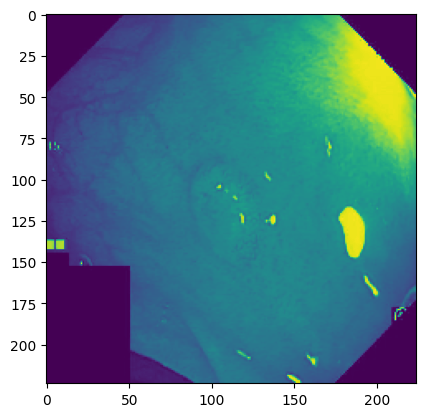

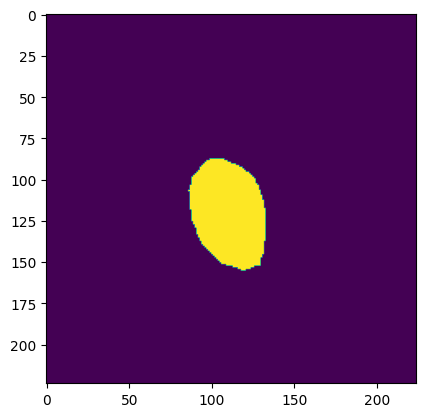

3픽셀의 평균값이라 색깔이 변경됨.


In [8]:
# Show example images.
image_number = 23
img, mask = custom_dataset_train.__getitem__(image_number)

# image
plt.figure()
plt.imshow(img.mean(0)) # 3 channels, take mean

# mask
plt.figure()
plt.imshow(mask[0, :, :]) # 1 channel, take it

plt.show()
print('3픽셀의 평균값이라 색깔이 변경됨.')

# 3. 모델 클래스 생성

In [9]:
from models.FCBformer.FCBmodels import FCBFormer

model = FCBFormer(size=224)
model = model.to(DEVICE)

# 4. 하이퍼 파라미터 세팅 & 데이터 로더 생성

In [10]:
# Define variables for the training
epochs = 100
patience = 20
BATCH_SIZE = 8

dataloader_train = torch.utils.data.DataLoader(custom_dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
dataloader_val = torch.utils.data.DataLoader(custom_dataset_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [11]:
# Define optimiser and criterion for the training. You can try different ones to see which works best for your data and task
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay = 1e-8)

criterion = DiceBCELoss()
model_name = 'FCBFormer'
data_name = 'Kvasir'

# 5. Training

/home/ehdgus575/.conda/envs/cuda_setting/lib/python3.9/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 Epoch: 1 of 100, Iter.: 100 of 100, Train Loss: 0.487690, IoU: 0.651988, Dice: 0.757560
 Epoch: 1 of 100, Iter.: 100 of 100, Valid Loss: 0.363220, IoU: 0.765221, Dice: 0.853816

시각화되는 이미지는 1.실제 테스트 이미지 2.실제 라벨 이미지 3.예측 라벨 4.예측한 이미지 결과의 순서입니다.


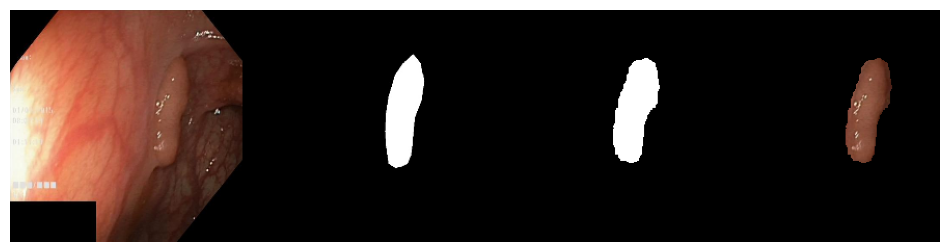

 Epoch: 2 of 100, Iter.: 100 of 100, Train Loss: 0.234817, IoU: 0.805612, Dice: 0.878688
 Epoch: 2 of 100, Iter.: 100 of 100, Valid Loss: 0.329886, IoU: 0.756472, Dice: 0.850404


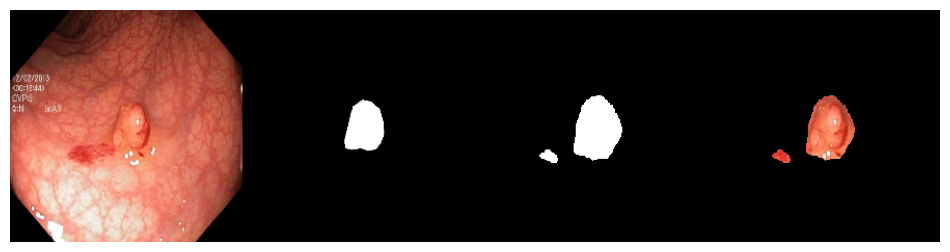

 Epoch: 3 of 100, Iter.: 100 of 100, Train Loss: 0.166713, IoU: 0.846283, Dice: 0.907937
 Epoch: 3 of 100, Iter.: 100 of 100, Valid Loss: 0.275639, IoU: 0.818807, Dice: 0.887059


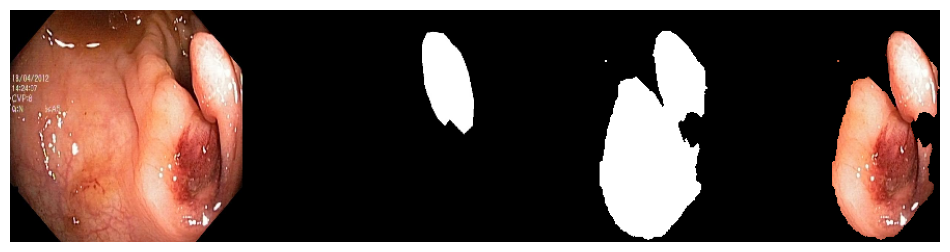

 Epoch: 4 of 100, Iter.: 100 of 100, Train Loss: 0.117732, IoU: 0.882882, Dice: 0.932918
 Epoch: 4 of 100, Iter.: 100 of 100, Valid Loss: 0.231576, IoU: 0.828454, Dice: 0.897115


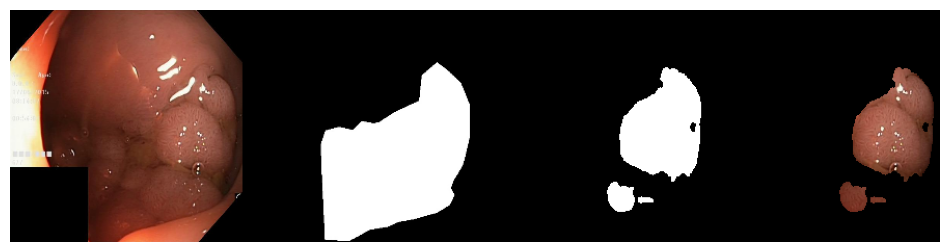

 Epoch: 5 of 100, Iter.: 100 of 100, Train Loss: 0.090904, IoU: 0.903849, Dice: 0.946900
 Epoch: 5 of 100, Iter.: 100 of 100, Valid Loss: 0.226655, IoU: 0.845606, Dice: 0.907104


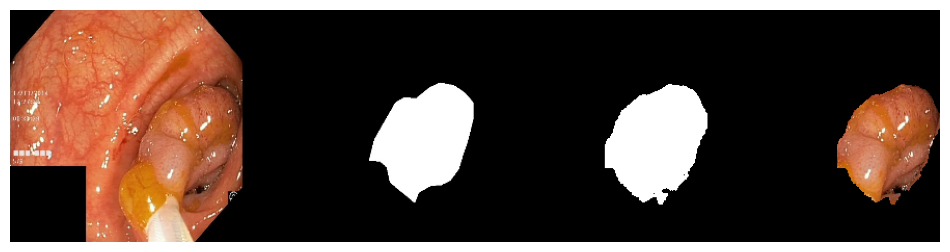

 Epoch: 6 of 100, Iter.: 100 of 100, Train Loss: 0.071482, IoU: 0.918451, Dice: 0.955406
 Epoch: 6 of 100, Iter.: 100 of 100, Valid Loss: 0.208511, IoU: 0.846858, Dice: 0.909508


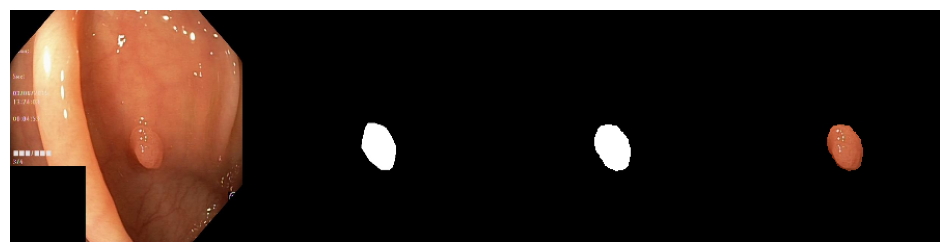

 Epoch: 7 of 100, Iter.: 100 of 100, Train Loss: 0.061008, IoU: 0.928845, Dice: 0.961798
 Epoch: 7 of 100, Iter.: 100 of 100, Valid Loss: 0.231051, IoU: 0.845231, Dice: 0.906472


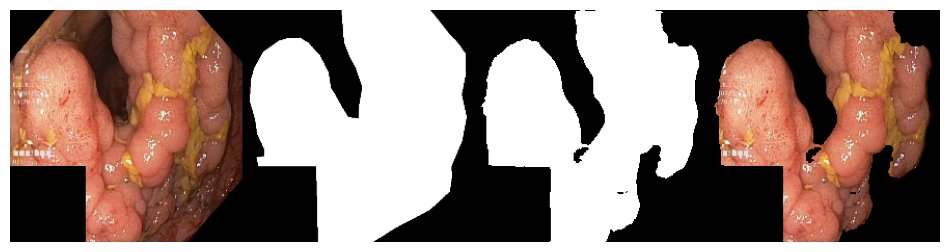

 Epoch: 8 of 100, Iter.: 100 of 100, Train Loss: 0.048266, IoU: 0.940438, Dice: 0.968714
 Epoch: 8 of 100, Iter.: 100 of 100, Valid Loss: 0.229824, IoU: 0.854099, Dice: 0.913138


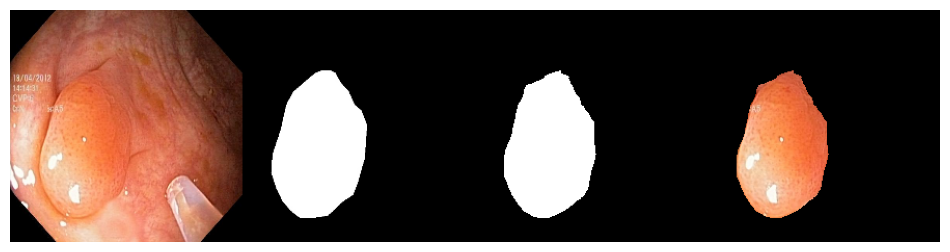

 Epoch: 9 of 100, Iter.: 100 of 100, Train Loss: 0.043418, IoU: 0.945916, Dice: 0.971679
 Epoch: 9 of 100, Iter.: 100 of 100, Valid Loss: 0.239897, IoU: 0.852848, Dice: 0.913086


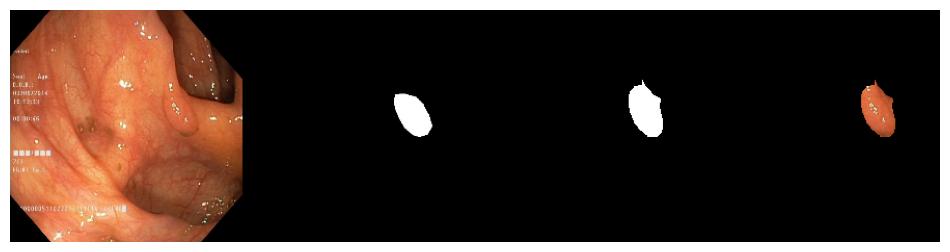

 Epoch: 10 of 100, Iter.: 100 of 100, Train Loss: 0.039662, IoU: 0.949895, Dice: 0.973864
 Epoch: 10 of 100, Iter.: 100 of 100, Valid Loss: 0.238659, IoU: 0.856883, Dice: 0.915902


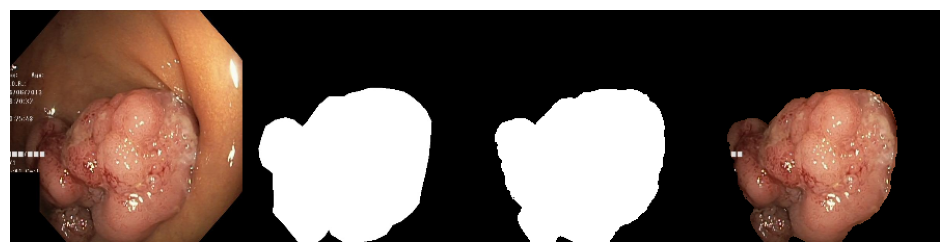

 Epoch: 11 of 100, Iter.: 100 of 100, Train Loss: 0.034818, IoU: 0.954811, Dice: 0.976520
 Epoch: 11 of 100, Iter.: 100 of 100, Valid Loss: 0.241994, IoU: 0.855373, Dice: 0.914361


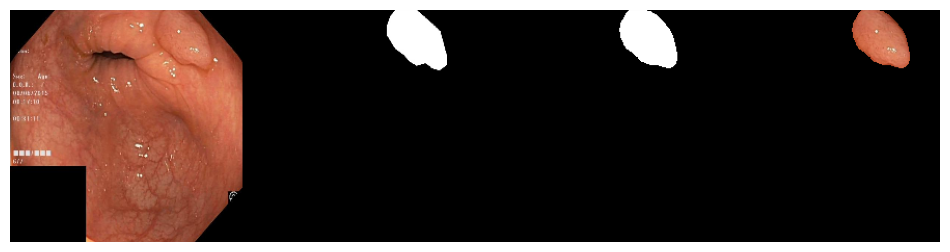

 Epoch: 12 of 100, Iter.: 100 of 100, Train Loss: 0.032239, IoU: 0.958641, Dice: 0.978641
 Epoch: 12 of 100, Iter.: 100 of 100, Valid Loss: 0.255736, IoU: 0.853151, Dice: 0.913234


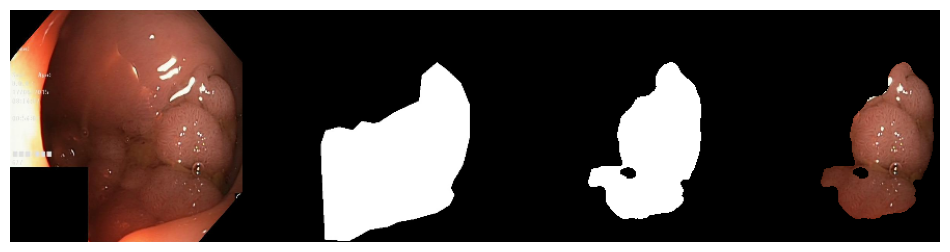

 Epoch: 13 of 100, Iter.: 100 of 100, Train Loss: 0.030106, IoU: 0.961266, Dice: 0.980072
 Epoch: 13 of 100, Iter.: 100 of 100, Valid Loss: 0.256054, IoU: 0.857087, Dice: 0.916146


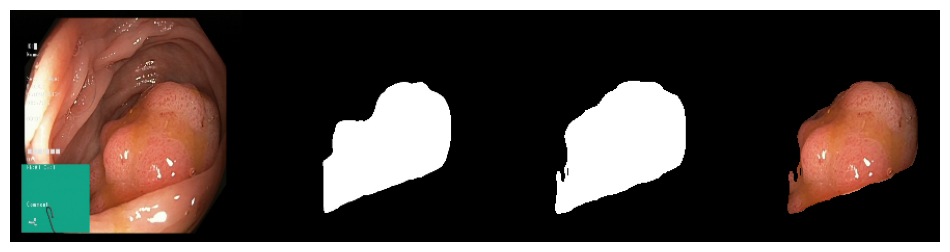

 Epoch: 14 of 100, Iter.: 100 of 100, Train Loss: 0.028012, IoU: 0.963323, Dice: 0.981145
 Epoch: 14 of 100, Iter.: 100 of 100, Valid Loss: 0.255084, IoU: 0.854886, Dice: 0.913572


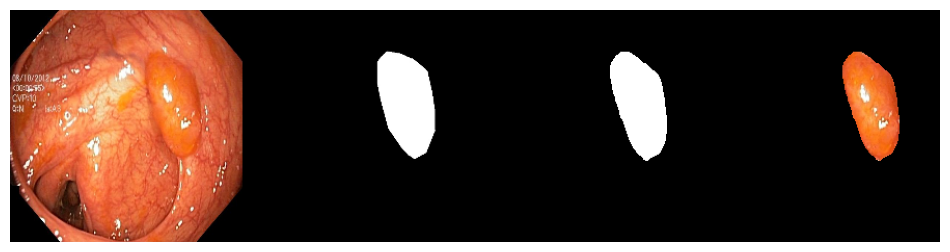

 Epoch: 15 of 100, Iter.: 100 of 100, Train Loss: 0.026389, IoU: 0.965186, Dice: 0.982136
 Epoch: 15 of 100, Iter.: 100 of 100, Valid Loss: 0.276819, IoU: 0.849085, Dice: 0.908931


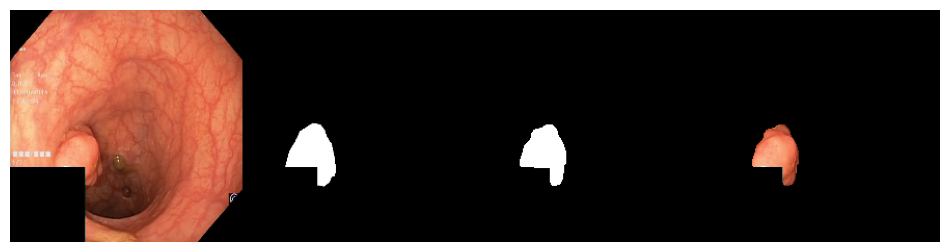

 Epoch: 16 of 100, Iter.: 100 of 100, Train Loss: 0.024245, IoU: 0.967704, Dice: 0.983440
 Epoch: 16 of 100, Iter.: 100 of 100, Valid Loss: 0.280491, IoU: 0.852947, Dice: 0.912394


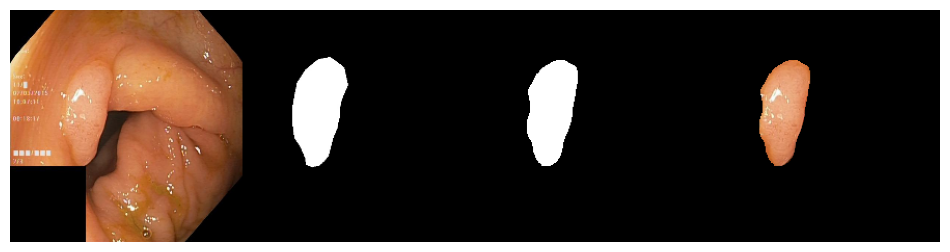

 Epoch: 17 of 100, Iter.: 100 of 100, Train Loss: 0.021804, IoU: 0.970520, Dice: 0.984891
 Epoch: 17 of 100, Iter.: 100 of 100, Valid Loss: 0.291263, IoU: 0.852198, Dice: 0.911939


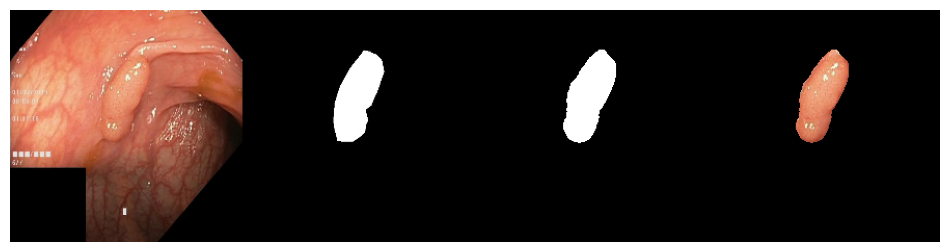

 Epoch: 18 of 100, Iter.: 100 of 100, Train Loss: 0.020233, IoU: 0.972901, Dice: 0.986150
 Epoch: 18 of 100, Iter.: 100 of 100, Valid Loss: 0.302254, IoU: 0.851369, Dice: 0.911403


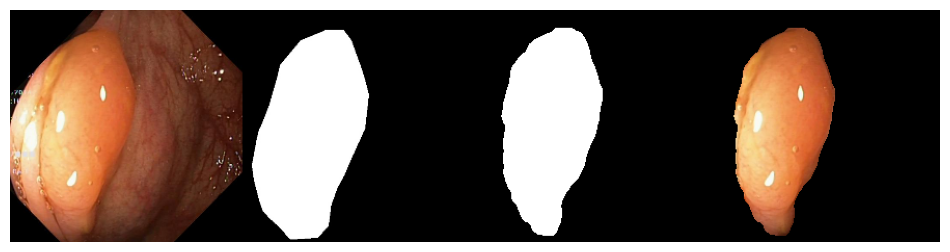

 Epoch: 19 of 100, Iter.: 100 of 100, Train Loss: 0.019232, IoU: 0.974208, Dice: 0.986847
 Epoch: 19 of 100, Iter.: 100 of 100, Valid Loss: 0.296880, IoU: 0.853989, Dice: 0.912729


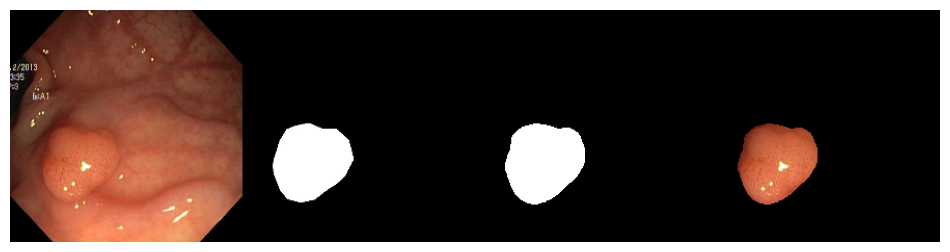

 Epoch: 20 of 100, Iter.: 100 of 100, Train Loss: 0.017455, IoU: 0.976352, Dice: 0.987965
 Epoch: 20 of 100, Iter.: 100 of 100, Valid Loss: 0.313197, IoU: 0.852835, Dice: 0.912548


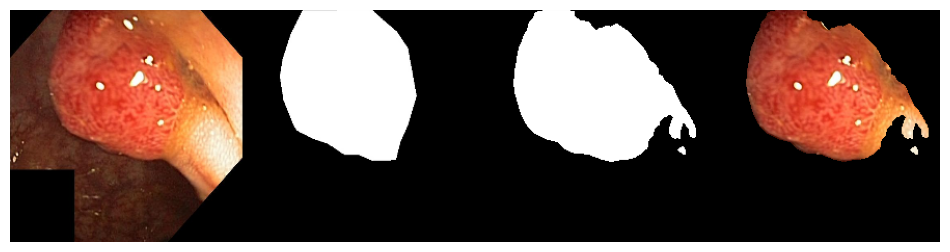

 Epoch: 21 of 100, Iter.: 100 of 100, Train Loss: 0.017132, IoU: 0.977481, Dice: 0.988564
 Epoch: 21 of 100, Iter.: 100 of 100, Valid Loss: 0.320513, IoU: 0.852324, Dice: 0.911500


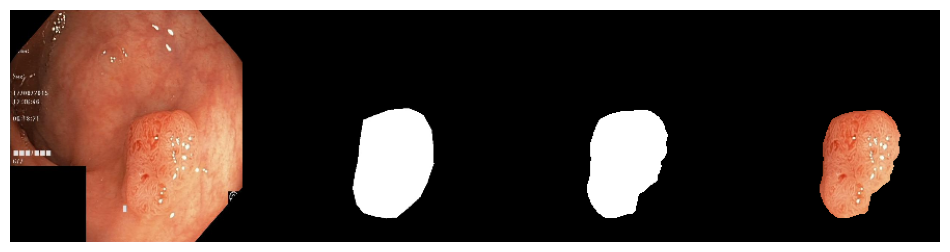

 Epoch: 22 of 100, Iter.: 100 of 100, Train Loss: 0.016828, IoU: 0.977311, Dice: 0.988459
 Epoch: 22 of 100, Iter.: 100 of 100, Valid Loss: 0.308610, IoU: 0.856254, Dice: 0.914712


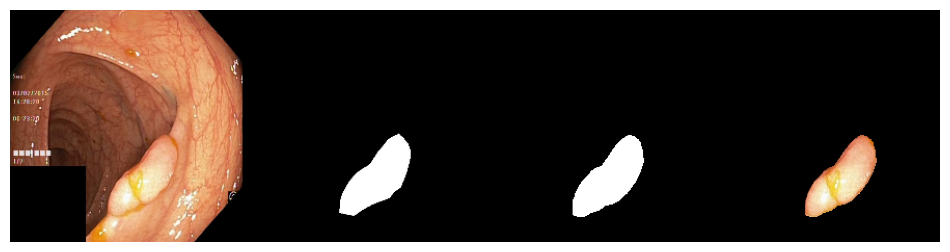

 Epoch: 23 of 100, Iter.: 100 of 100, Train Loss: 0.014898, IoU: 0.979755, Dice: 0.989724
 Epoch: 23 of 100, Iter.: 100 of 100, Valid Loss: 0.326245, IoU: 0.854219, Dice: 0.913079


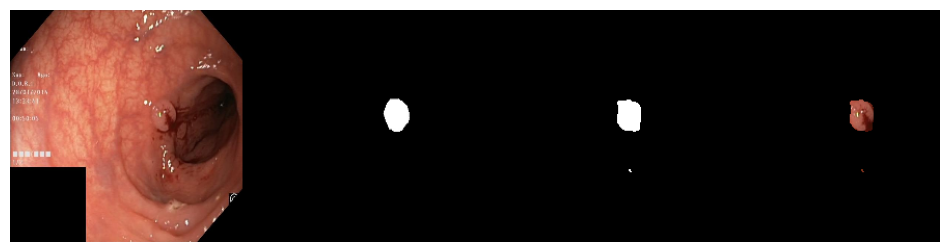

 Epoch: 24 of 100, Iter.: 100 of 100, Train Loss: 0.013273, IoU: 0.981993, Dice: 0.990873
 Epoch: 24 of 100, Iter.: 100 of 100, Valid Loss: 0.366335, IoU: 0.850387, Dice: 0.910572


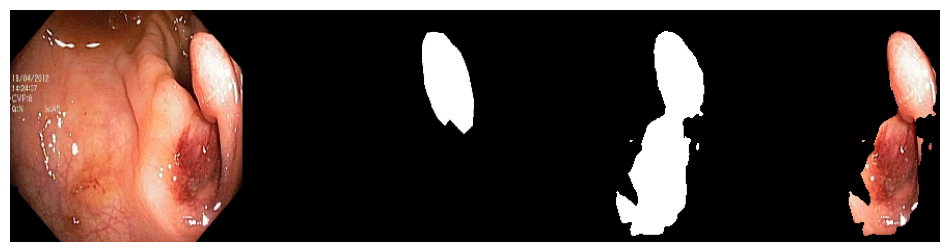

 Epoch: 25 of 100, Iter.: 100 of 100, Train Loss: 0.012995, IoU: 0.982085, Dice: 0.990925
 Epoch: 25 of 100, Iter.: 100 of 100, Valid Loss: 0.368459, IoU: 0.853972, Dice: 0.912572


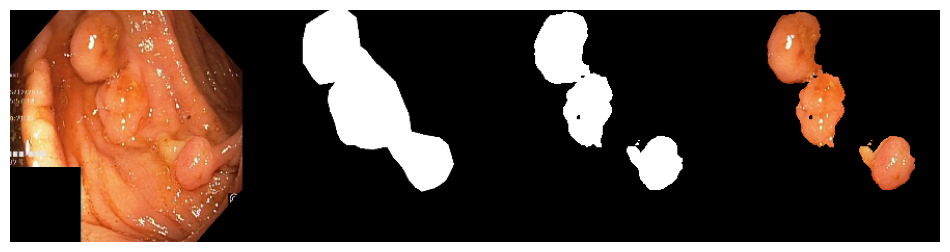

 Epoch: 26 of 100, Iter.: 100 of 100, Train Loss: 0.013119, IoU: 0.982003, Dice: 0.990880
 Epoch: 26 of 100, Iter.: 100 of 100, Valid Loss: 0.376129, IoU: 0.856398, Dice: 0.914062


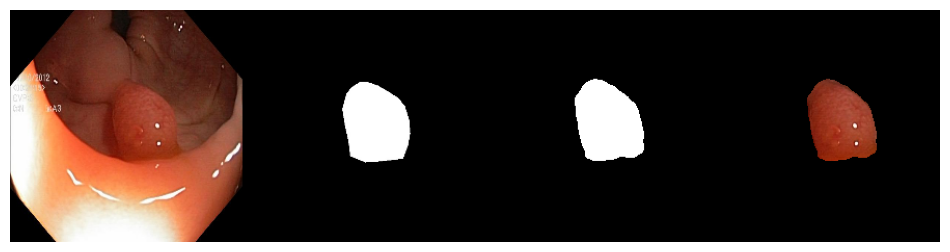

 Epoch: 27 of 100, Iter.: 100 of 100, Train Loss: 0.013095, IoU: 0.981979, Dice: 0.990866
 Epoch: 27 of 100, Iter.: 100 of 100, Valid Loss: 0.359193, IoU: 0.855534, Dice: 0.913340


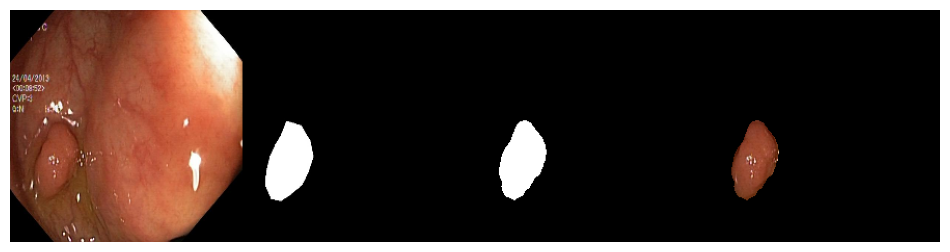

 Epoch: 28 of 100, Iter.: 100 of 100, Train Loss: 0.012036, IoU: 0.983574, Dice: 0.991687
 Epoch: 28 of 100, Iter.: 100 of 100, Valid Loss: 0.375643, IoU: 0.855129, Dice: 0.913494


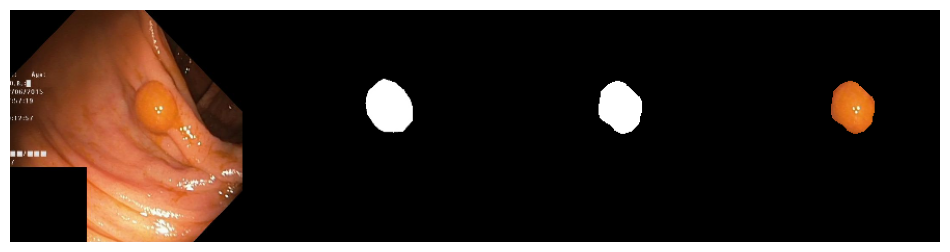

 Epoch: 29 of 100, Iter.: 100 of 100, Train Loss: 0.011196, IoU: 0.984681, Dice: 0.992253
 Epoch: 29 of 100, Iter.: 100 of 100, Valid Loss: 0.407036, IoU: 0.854814, Dice: 0.913078


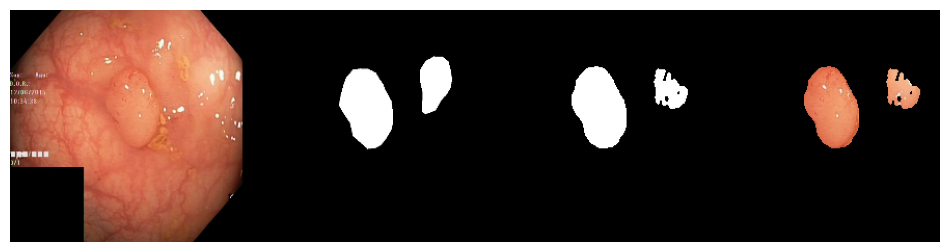

 Epoch: 30 of 100, Iter.: 100 of 100, Train Loss: 0.010603, IoU: 0.985290, Dice: 0.992563
 Epoch: 30 of 100, Iter.: 100 of 100, Valid Loss: 0.418952, IoU: 0.854713, Dice: 0.912974


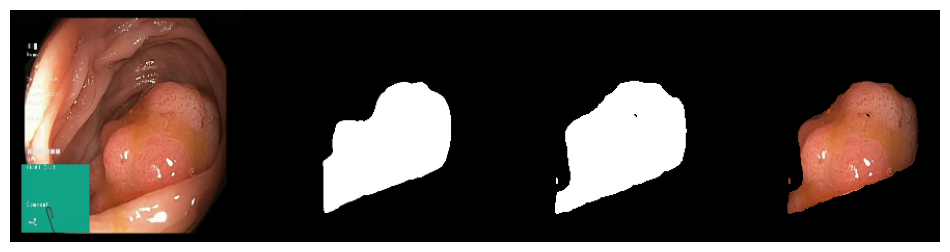

 Epoch: 31 of 100, Iter.: 100 of 100, Train Loss: 0.010778, IoU: 0.984867, Dice: 0.992345
 Epoch: 31 of 100, Iter.: 100 of 100, Valid Loss: 0.435369, IoU: 0.856059, Dice: 0.914071


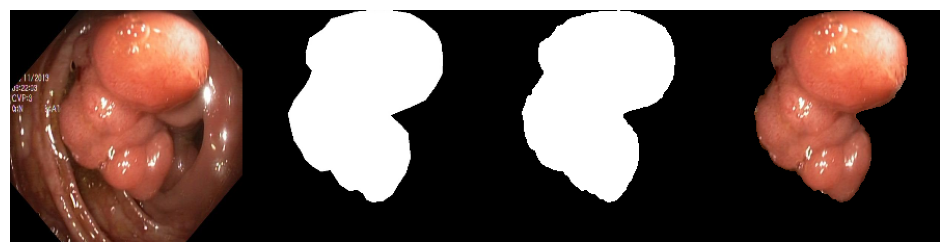

 Epoch: 32 of 100, Iter.: 100 of 100, Train Loss: 0.010793, IoU: 0.985150, Dice: 0.992482
 Epoch: 32 of 100, Iter.: 100 of 100, Valid Loss: 0.437392, IoU: 0.855904, Dice: 0.913467


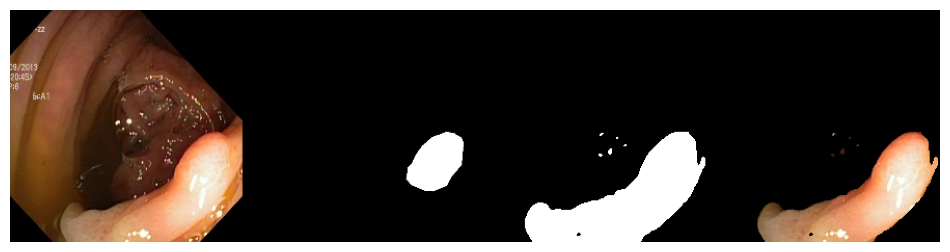

 Epoch: 33 of 100, Iter.: 100 of 100, Train Loss: 0.010378, IoU: 0.985471, Dice: 0.992647
 Epoch: 33 of 100, Iter.: 100 of 100, Valid Loss: 0.433510, IoU: 0.854579, Dice: 0.913025


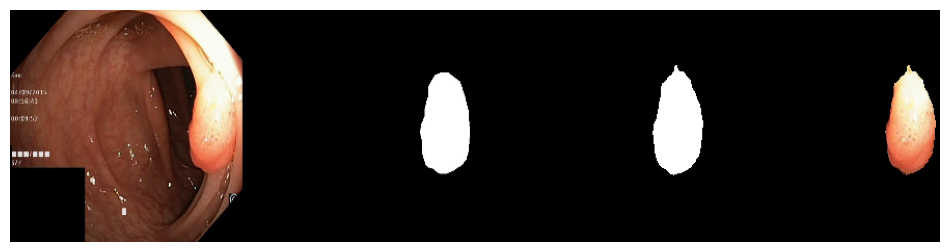

 Epoch: 34 of 100, Iter.: 100 of 100, Train Loss: 0.009479, IoU: 0.986926, Dice: 0.993399
 Epoch: 34 of 100, Iter.: 100 of 100, Valid Loss: 0.460552, IoU: 0.854780, Dice: 0.912966


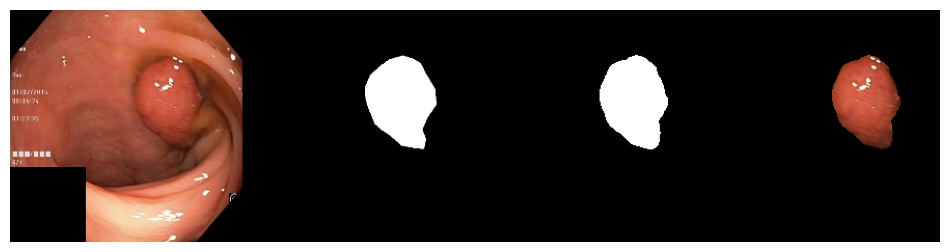


Early stopping. Target criteria has not improved for 20 epochs.

CPU times: user 1h 27min 28s, sys: 39min 1s, total: 2h 6min 29s
Wall time: 2h 4min 2s


In [12]:
%%time
from ploting import plot_model_prediction

train_losses, val_losses = [], []
train_ious, val_ious = [], []
train_dices, val_dices = [], []
best_iou, best_dice, best_loss = 0, 0, np.inf
best_epoch_dice = -1
state = {}
lst_epoch_metric = []

start_time = time.time()
for epoch in range(1, epochs+1):
    running_loss, running_iou, running_dice = 0, 0, 0

    # Train
    model.train()
    for i, (imgs, masks) in enumerate(dataloader_train):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        
        prediction = model(imgs)
        
        optimizer.zero_grad()
        loss = criterion(prediction, masks)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        running_iou += iou_pytorch_eval(prediction, masks)
        running_dice += dice_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, Loss: {:.6f}, IoU:  {:.6f},  Dice:  {:.6f}".format(epoch, epochs, i, len(dataloader_train), running_loss/(i+1), running_iou/(i+1), running_dice/(i+1)), end="")
        
    # Validate
    model.eval()
    val_loss, val_iou, val_dice = 0, 0, 0
    for i, (imgs, masks) in enumerate(dataloader_val):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        
        prediction = model(imgs)
        loss = criterion(prediction, masks)
        val_loss += loss.item()
        print("\r Epoch: {} of {}, Iter.: {} of {}, Loss: {:.6f}, Val. Loss: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_loss/len(dataloader_train), val_loss/(i+1)), end="")
        
        val_iou += iou_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, IoU: {:.6f}, Val. IoU: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_iou/len(dataloader_train), val_iou/(i+1)), end="")

        val_dice += dice_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, Dice: {:.6f}, Val. Dice: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_dice/len(dataloader_train), val_dice/(i+1)), end="")
    
    
    # compute overall epoch losses
    epoch_train_loss = running_loss/len(dataloader_train)
    train_losses.append(epoch_train_loss)
    epoch_val_loss = val_loss/len(dataloader_val)
    val_losses.append(epoch_val_loss)

    # compute overall epoch iou-s
    epoch_train_iou = (running_iou/len(dataloader_train)).item()
    train_ious.append(epoch_train_iou)
    epoch_val_iou = (val_iou/len(dataloader_val)).item()
    val_ious.append(epoch_val_iou)
    
    # compute overall epoch dice
    epoch_train_dice = (running_dice/len(dataloader_train)).item()
    train_dices.append(epoch_train_dice)
    epoch_val_dice = (val_dice/len(dataloader_val)).item()
    val_dices.append(epoch_val_dice)

    print("\r Epoch: {} of {}, Iter.: {} of {}, Train Loss: {:.6f}, IoU: {:.6f}, Dice: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), epoch_train_loss, epoch_train_iou, epoch_train_dice))
    print("\r Epoch: {} of {}, Iter.: {} of {}, Valid Loss: {:.6f}, IoU: {:.6f}, Dice: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), epoch_val_loss, epoch_val_iou, epoch_val_dice))
    
    if epoch == 1:
        print('\n시각화되는 이미지는 1.실제 테스트 이미지 2.실제 라벨 이미지 3.예측 라벨 4.예측한 이미지 결과의 순서입니다.')
    plot_model_prediction(model, DEVICE, valid_images, valid_labels)
        
    # plot
    metrics = {'loss':[train_losses, epoch_train_loss, val_losses, epoch_val_loss],
               'Iou':[train_ious, epoch_train_iou, val_ious,  epoch_val_iou],
               'Dice':[train_dices, epoch_train_dice, val_dices,  epoch_val_dice]}
    
    lst_epoch_metric.append([round(epoch_train_loss,4), round(epoch_train_iou,4), round(epoch_train_dice,4), 
                             round(epoch_val_loss,4), round(epoch_val_iou,4), round(epoch_val_dice,4)]) 

    # save if best results or break is has not improved for {patience} number of epochs
    best_iou = max(best_iou, epoch_val_iou)
    best_dice = max(best_dice, epoch_val_dice)
    best_loss = min(best_loss, epoch_val_loss)
    best_epoch_dice = epoch if best_dice == epoch_val_dice else best_epoch_dice

    # record losses
    state['train_losses'] = train_losses
    state['val_losses'] = val_losses
    
    if best_epoch_dice == epoch:
        # print('Saving..')
        state['net'] = model.state_dict()
        state['dice'] = best_dice
        state['epoch'] = epoch
            
        if not os.path.isdir('checkpoints'):
            os.mkdir('checkpoints')
        torch.save(state, f'./checkpoints/ckpt_{model_name}_{data_name}.pth')
    
    
    elif best_epoch_dice + patience < epoch:
        print(f"\nEarly stopping. Target criteria has not improved for {patience} epochs.\n")
        break

file_name = f'{model_name}_{data_name}'
# load once more and write all the losses down (othw can miss the last 10)
end_time = time.time() - start_time

state = torch.load(f'./checkpoints/ckpt_{model_name}_{data_name}.pth')
state['train_losses'] = train_losses
state['val_losses'] = val_losses
torch.save(state, f'./checkpoints/ckpt_{model_name}_{data_name}.pth')

df_epoch_metric = pd.DataFrame(lst_epoch_metric, columns = ['epoch_train_loss', 'epoch_train_iou', 'epoch_train_dice', 'epoch_val_loss', 'epoch_val_iou', 'epoch_val_dice'])
df_epoch_metric.to_csv(f'/project/segmentation/ehdgus575/training_{model_name}/csv_{file_name}.csv', index_label = ['epoch'])

Validationset 기준 
Best_epoch:13, Best_IOU:0.8571, Best_DiceScore:0.9161


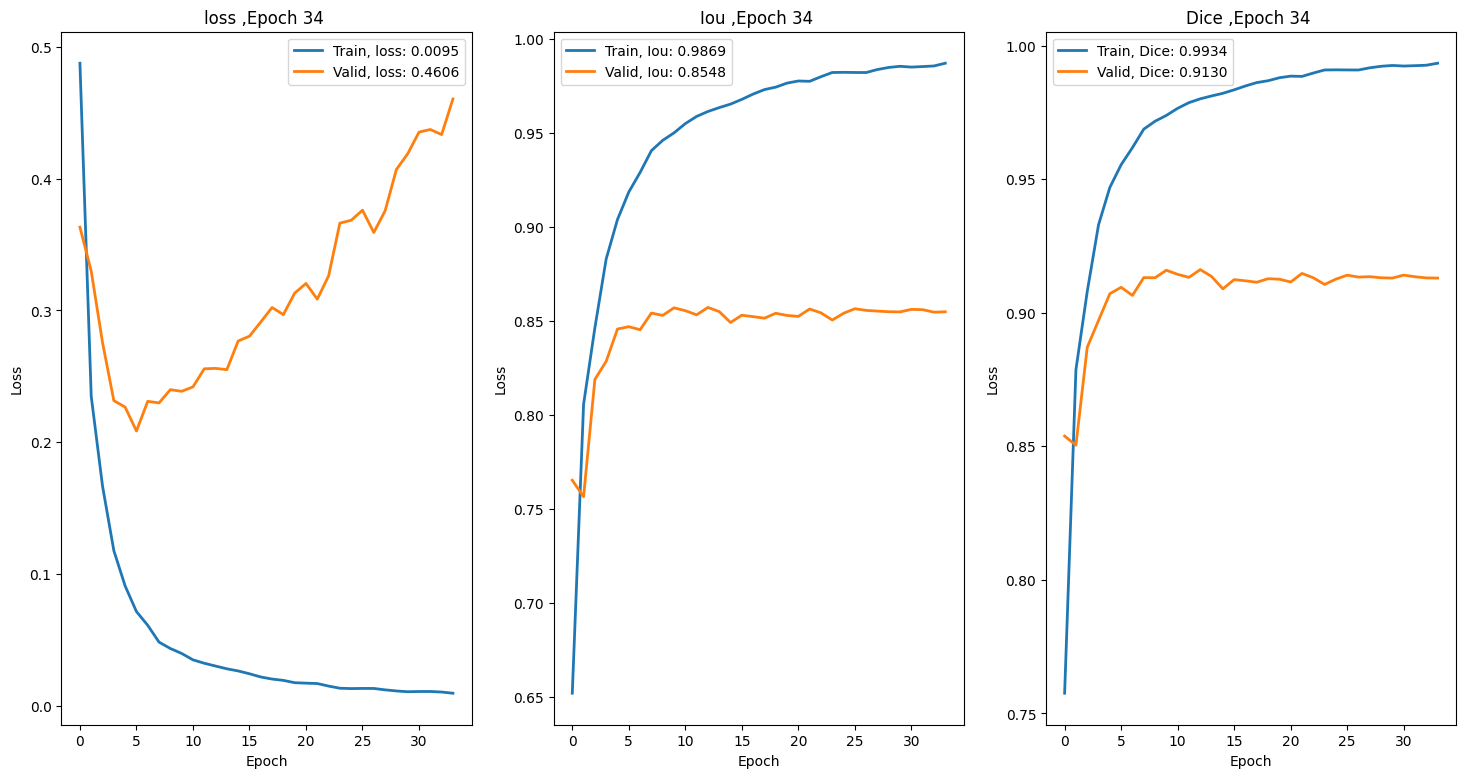

In [13]:
print(f'Validationset 기준 \nBest_epoch:{best_epoch_dice}, Best_IOU:{best_iou:.4f}, Best_DiceScore:{best_dice:.4f}')
#print(f'End_time: {end_time}')

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 9))           
for i, (metric, value) in enumerate(metrics.items()):
    axs[i].plot(np.arange(len(value[0])), value[0], label=f'Train, {metric}: {value[1]:.4f}', linewidth=2)
    axs[i].plot(np.arange(len(value[2])), value[2], label=f'Valid, {metric}: {value[3]:.4f}', linewidth=2)
    axs[i].set_xlabel('Epoch')
    axs[i].set_ylabel('Loss')
    axs[i].set_title(f'{metric} ,Epoch {epoch} ')
    axs[i].legend(loc='best')
plt.show()